# RQ6: What are prevalent code smells in Dockerfiles?

## Load data and import libraries

In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import datetime
import re
import subprocess
import os
import json
from tqdm import tqdm_notebook, _tqdm_notebook

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

In [2]:
data_folder = '../data/'

docker_image_dataset = pd.read_csv(data_folder + 'docker_image_dataset.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
dockerimage_dataset = docker_image_dataset[docker_image_dataset['collection_method'].notnull()].copy()
dockerimage_dataset.index=range(0,dockerimage_dataset.shape[0])

## Define helper functions and defaults

In [3]:
# Helper Functions
!mkdir figs
figs_dir = 'figs/'

mkdir: cannot create directory ‘figs’: File exists


In [4]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rc('text', usetex=True) # enable latex    
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    
set_plt_rc()

### Use Haskell Dockerfile Linter to analyze Dockerfiles
* Haskell Dockerfile Linter must be installed to execute the following code block.
* Installation Instructions: https://github.com/hadolint/hadolint
* The following two code blocks may take few hours to execute.
* The following two code blocks can be skipped as the SAT result was already stored in the data folder.

In [5]:
# Function for using hadolint AST to analyze Dockerfile
def hadolint(dockerfile_str):
    file_name = 'Dockerfile_hadolint_temp'  
    with open(file_name, 'w') as file:
        file.write(dockerfile_str)
    proc_hadolint = subprocess.Popen(['hadolint', '-f', 'json', 'Dockerfile_hadolint_temp'],
                                   stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    hadolint_result = proc_hadolint.communicate()[0].decode('utf-8')
    os.remove('Dockerfile_hadolint_temp')
    return json.loads(hadolint_result)

In [6]:
#drop duplicated dockerfile
dockerfiles=dockerimage_dataset.iloc[dockerimage_dataset['latest_dockerfile'].drop_duplicates(keep="first").index].copy()
dockerfiles.index=range(0,dockerfiles.shape[0])

In [7]:
smell_count=pd.Series([np.nan]*len(dockerfiles['latest_dockerfile']))
violated_rule=pd.Series([np.nan]*len(dockerfiles['latest_dockerfile']))
if(os.path.isfile('Dockerfile_hadolint_temp')):
    os.remove('Dockerfile_hadolint_temp')
list_range=range(0,len(dockerfiles['latest_dockerfile']))
for i in tqdm_notebook(list_range):
    result=hadolint(str(dockerfiles['latest_dockerfile'][i]))
    smell_count[i]=len(result)
    if(len(result)!=0):
        error_list=[]
        for item in result:
            error_list.append(item['code'])
        violated_rule[i]=error_list
RQ6_SAT_result=pd.concat([dockerfiles['image_name'],dockerfiles['latest_dockerfile'],smell_count,violated_rule],axis=1,keys=['image_name','latest_dockerfile','smell_count','violated_rule'])
RQ6_SAT_result.to_csv(data_folder +'RQ6_SAT_result.csv',index=False)
RQ6_SAT_result = pd.read_csv(data_folder + 'RQ6_SAT_result.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)

HBox(children=(IntProgress(value=0, max=246618), HTML(value='')))

### Smell Count Distribution

In [8]:
RQ6_SAT_result = pd.read_csv(data_folder + 'RQ6_SAT_result.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)

def get_dockerfile_update_year(l):
    if(type(l)!=list):
        return np.nan
    elif(len(l)==0):
        return np.nan
    else:
        return max(l).year
    
dockerfiles['dockerfile_commit_date']=dockerfiles['dockerfile_commit_date'].apply(lambda x: np.nan if pd.isna(x) else eval(x.replace('Timestamp','pd.Timestamp')))
dockerfile_update_year=dockerfiles['dockerfile_commit_date'].apply(lambda x: np.nan if type(x)!=list else get_dockerfile_update_year(x))
RQ6_SAT_result['update_year']=dockerfile_update_year

In [9]:
smell_count=RQ6_SAT_result['smell_count']
weights=smell_count.value_counts()/len(smell_count)
print('Average smell count in Dockerfiles: ',smell_count.mean())
print('The median of smell count in Dockerfiles: ',smell_count.median())
print('25th quantile of smell count in Dockerfiles: ',smell_count.quantile(.25))
print('75th quantile of smell count in Dockerfiles: ',smell_count.quantile(.75))
print('Proportion of Dockerfiles which are code smell-free: {}%'.format(weights[0]*100.0))
print('Proportion of Dockerfiles which contain 1 to 3 code smells: {}%'.format(np.sum(weights[1:3])*100.0))
print('Proportion of Dockerfiles which contain 5 or more code smells: {}%'.format((1-(np.sum(weights[:4])+weights[0]))*100.0))

Average smell count in Dockerfiles:  4.133550673511261
The median of smell count in Dockerfiles:  3.0
25th quantile of smell count in Dockerfiles:  1.0
75th quantile of smell count in Dockerfiles:  5.0
Proportion of Dockerfiles which are code smell-free: 9.927093723896876%
Proportion of Dockerfiles which contain 1 to 3 code smells: 46.426457111808546%
Proportion of Dockerfiles which contain 5 or more code smells: 31.666382826882067%


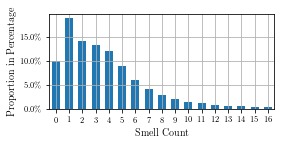

In [10]:
fig=plt.figure(figsize=(4,2))
ax=plt.subplot(111)
ax.set_xlim(0,16)
ax.grid()
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
plt.xlim([-0.5, 16.5])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_ylabel("Proportion in Percentage")
ax.set_xlabel('Smell Count')
plt.hist(smell_count, bins=18,rwidth=0.6,align='left',range=(0,18), weights=np.ones(len(smell_count)) / len(smell_count))
fig.tight_layout()
fig.savefig(figs_dir+'smell-count-distribution', dpi=300)
fig.savefig(figs_dir+'smell-count-distribution.pdf')

### The average total number of code smells in Dockerfiles over time

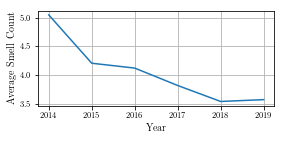

In [11]:
count_data=[]
year_list = range(2014, 2020)
for year in year_list:
    smell_count=RQ6_SAT_result[RQ6_SAT_result['update_year']==year]['smell_count']
    avg=smell_count.mean()
    std=smell_count.std()
    smell_count=smell_count[smell_count<=16]
    count_data.append(smell_count.mean())
fig=plt.figure(figsize=(4,2))
ax=plt.subplot(111)
ax.set_ylabel("Average Smell Count")
ax.set_xlabel('Year')
ax.grid()
plt.plot(year_list,count_data)
fig.tight_layout()
fig.savefig(figs_dir+'smell-count-over-time', dpi=300)
fig.savefig(figs_dir+'smell-count-over-time.pdf')

### Prevalent Code Smells in Dockerfiles
* The following code block may take twenty minutes to execute.
* The following code block can be skipped as the result was alread saved in the data folder.
* Best practices of writing Dockerfiles: https://docs.docker.com/develop/develop-images/dockerfile_best-practices/
* The definition of the rule code: https://github.com/hadolint/hadolint/wiki

In [12]:
violated_rule=RQ6_SAT_result['violated_rule']
violated_rule=violated_rule.dropna()
violated_rule=violated_rule.apply(lambda x: eval(x))
violated_rule.index=range(0,len(violated_rule))
prevalent_code_smell=pd.DataFrame(columns=['rule','count'])
list_range=range(0,len(violated_rule))
for i in tqdm_notebook(list_range):
    for item in violated_rule[i]:
        if(item in prevalent_code_smell['rule'].tolist()):
            prevalent_code_smell.loc[prevalent_code_smell['rule']==item, 'count']=prevalent_code_smell.loc[prevalent_code_smell['rule']==item, 'count'][prevalent_code_smell.loc[prevalent_code_smell['rule']==item, 'count'].index[0]]+1
        else:
            prevalent_code_smell=prevalent_code_smell.append(pd.Series([item, 1],index=prevalent_code_smell.columns),ignore_index=True)
prevalent_code_smell=prevalent_code_smell.sort_values('count',ascending=False)
prevalent_code_smell.to_csv(data_folder +'RQ6_prevalent_code_smell.csv',index=False)

HBox(children=(IntProgress(value=0, max=222136), HTML(value='')))

In [13]:
prevalent_code_smell=pd.read_csv(data_folder +'RQ6_prevalent_code_smell.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
top15_proportion=prevalent_code_smell['count'][:15]/prevalent_code_smell['count'].sum()
print('Top 15 most prevalent code smells in Dockerfiles:')
for i in range(15):
    print('{}  {}%'.format(prevalent_code_smell['rule'][i],top15_proportion[i]*100.0))

Top 15 most prevalent code smells in Dockerfiles:
DL3008  13.590632994836218%
DL3015  10.992556464143895%
DL3020  9.292648282140222%
DL4000  8.865439549228572%
DL3009  6.604323293519377%
DL4006  6.353883822767724%
DL3018  6.200167155839468%
DL3003  5.920298840111124%
DL3006  4.042248049848539%
DL3013  3.5152755324659015%
DL4001  3.0758047808139626%
DL3025  2.7890697345910564%
DL3007  2.763859024061024%
DL3019  2.3616648093795614%
SC2086  1.5918062247892895%


In [14]:
# Function for converting stringied list to list
def strlist2list(s):
    try:
        return(eval(s))
    except:
        return np.nan
RQ6_SAT_result['violated_rule'] = RQ6_SAT_result[
    'violated_rule'].apply(lambda x: strlist2list(x))
RQ6_SAT_result['update_year'] = pd.DatetimeIndex(
    dockerfiles['updated_at']).year
code_smell_trend = pd.DataFrame(columns=['rule', 'count', 'year'])
year_list = range(2014, 2020)
for year in year_list:
    violated_rule_year = RQ6_SAT_result[
        RQ6_SAT_result['update_year'] == year]['violated_rule']
    violated_rule_year = violated_rule_year.dropna()
    list_range = range(0, len(violated_rule_year))
    violated_rule_year.index = list_range
    for i in tqdm_notebook(list_range):
        for item in violated_rule_year[i]:
            if(item in code_smell_trend[code_smell_trend['year'] == year]['rule'].tolist()):
                code_smell_trend.loc[(code_smell_trend['rule'] == item) & (code_smell_trend['year'] == year), 'count'] = code_smell_trend.loc[(code_smell_trend[
                    'rule'] == item) & (code_smell_trend['year'] == year), 'count'][code_smell_trend.loc[(code_smell_trend['rule'] == item) & (code_smell_trend['year'] == year), 'count'].index[0]] + 1
            else:
                code_smell_trend = code_smell_trend.append(
                    pd.Series([item, 1, year], index=code_smell_trend.columns), ignore_index=True)
code_smell_trend.to_csv(data_folder + 'RQ6_code_smell_trend.csv', index=False)


HBox(children=(IntProgress(value=0, max=192), HTML(value='')))

HBox(children=(IntProgress(value=0, max=968), HTML(value='')))

HBox(children=(IntProgress(value=0, max=24360), HTML(value='')))

HBox(children=(IntProgress(value=0, max=39507), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62869), HTML(value='')))

HBox(children=(IntProgress(value=0, max=64831), HTML(value='')))

In [15]:
code_smell_trend = pd.read_csv(data_folder + 'RQ6_code_smell_trend.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
code_smell_trend['proportion']=pd.Series()
semll_count={}
for year in year_list:
    semll_count[year]=(code_smell_trend[code_smell_trend['year']==year]['count'].sum())
for i in range(len(code_smell_trend)):
    code_smell_trend.loc[i,['proportion']] = code_smell_trend['count'][i]/semll_count[code_smell_trend['year'][i]]*100.0

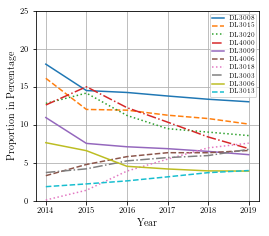

In [16]:
fig=plt.figure(figsize=(4,3.5))
ax=plt.subplot(111)
ax.grid()
ax.set_ylim(0,25)
cst=pd.Series(prevalent_code_smell[:10]['rule'])
for i in range(0,cst.size):
    ax.plot(year_list, code_smell_trend[code_smell_trend['rule']==cst[i]].sort_values(by=['year'])['proportion'], label=cst[i]) 
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Proportion in Percentage')
ax.legend(prop=dict(size=6))
fig.savefig(figs_dir+'popular-code-smells-over-time', dpi=300)
fig.savefig(figs_dir+'popular-code-smells-over-time.pdf')